In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the device to use (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Set the path to your dataset
dataset_dir = ""

# Set the input size for resizing the images
input_size = (128,128)

# Define the transformation to be applied to the images
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

In [3]:
# Load the training dataset
train_dataset = ImageFolder(root=os.path.join(dataset_dir, 'train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the test dataset
test_dataset = ImageFolder(root=os.path.join(dataset_dir, 'test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
# Load the pre-trained VGGNet model
model = vgg16(pretrained=True)
num_classes = len(train_dataset.classes)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alvin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:

# # Training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     train_correct = 0

#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         train_correct += (predicted == labels).sum().item()

#         loss = criterion(outputs, labels)
#         train_loss += loss.item()

#         loss.backward()
#         optimizer.step()

#     train_accuracy = train_correct / len(train_dataset)
#     train_loss /= len(train_loader)

#     # Evaluation on the test set
#     model.eval()
#     test_correct = 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             _, predicted = torch.max(outputs, 1)
#             test_correct += (predicted == labels).sum().item()

#     test_accuracy = test_correct / len(test_dataset)

#     print(f"Epoch [{epoch + 1}/{num_epochs}] Train Loss: {train_loss:.4f} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10] Train Loss: 0.5233 Train Accuracy: 0.8053 Test Accuracy: 0.7451
Epoch [2/10] Train Loss: 0.4363 Train Accuracy: 0.8456 Test Accuracy: 0.7318
Epoch [3/10] Train Loss: 0.6558 Train Accuracy: 0.7665 Test Accuracy: 0.8081
Epoch [4/10] Train Loss: 0.3580 Train Accuracy: 0.8614 Test Accuracy: 0.8607
Epoch [5/10] Train Loss: 0.3232 Train Accuracy: 0.8736 Test Accuracy: 0.8240
Epoch [6/10] Train Loss: 0.3517 Train Accuracy: 0.8703 Test Accuracy: 0.8718
Epoch [7/10] Train Loss: 0.2410 Train Accuracy: 0.9074 Test Accuracy: 0.8811
Epoch [8/10] Train Loss: 0.2991 Train Accuracy: 0.8860 Test Accuracy: 0.8770
Epoch [9/10] Train Loss: 0.4221 Train Accuracy: 0.8575 Test Accuracy: 0.7092
Epoch [10/10] Train Loss: 0.3757 Train Accuracy: 0.8578 Test Accuracy: 0.8692


In [5]:
# Path for the saved model
path = './models/vggnet16.pt'
# torch.save(model.state_dict(), path)

In [6]:
# Calculate the final accuracy on the entire test dataset
model.load_state_dict(torch.load(path))
model.eval()
test_correct = 0

preds_tensor = torch.Tensor()
labels_tensor = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        preds_tensor = torch.cat((preds_tensor, predicted))
        labels_tensor = torch.cat((labels_tensor, labels))
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = test_correct / len(test_dataset)
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


Final Test Accuracy: 0.8692


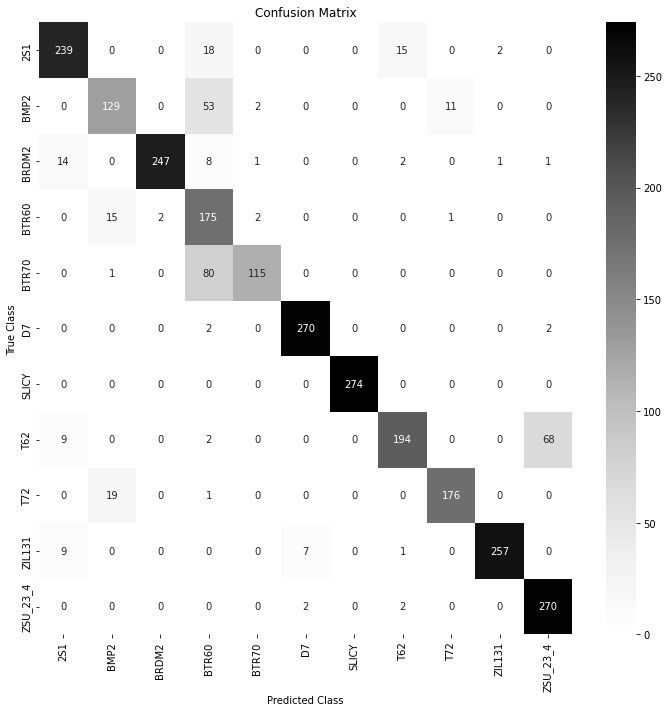

In [7]:
preds = preds_tensor.numpy()
actual = labels_tensor.numpy()

# Define the mapping dictionary
class_mapping = {
    0: '2S1',
    1: 'BMP2',
    2: 'BRDM2',
    3: 'BTR60',
    4: 'BTR70',
    5: 'D7',
    6: 'SLICY',
    7: 'T62',
    8: 'T72',
    9: 'ZIL131',
    10: 'ZSU_23_4'
}

y_preds = np.array([class_mapping[value] for value in preds])
y_true = np.array([class_mapping[value] for value in actual])

class_labels = ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70',
                'D7', 'SLICY', 'T62', 'T72', 'ZIL131', 'ZSU_23_4']

# Create the confusion matrix
cm = confusion_matrix(y_true, y_preds, labels=class_labels)

# Set figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Create the heatmap using Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Configure figure properties
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()

# Show the figure
plt.show()

In [28]:
class_wise_accuracies = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))

# Display the class-wise accuracies
for i, accuracy in enumerate(class_wise_accuracies):
    label = class_labels[i]
    print(f'Accuracy of class {label}: {accuracy:.2%}')

Accuracy of class 2S1: 78.10%
Accuracy of class BMP2: 56.09%
Accuracy of class BRDM2: 89.49%
Accuracy of class BTR60: 48.75%
Accuracy of class BTR70: 57.21%
Accuracy of class D7: 95.41%
Accuracy of class SLICY: 100.00%
Accuracy of class T62: 66.21%
Accuracy of class T72: 84.62%
Accuracy of class ZIL131: 92.78%
Accuracy of class ZSU_23_4: 78.26%


In [25]:
from sklearn.metrics import classification_report

classification_report(y_true, y_preds, labels=class_labels, output_dict=True)

{'2S1': {'precision': 0.8819188191881919,
  'recall': 0.8722627737226277,
  'f1-score': 0.8770642201834863,
  'support': 274},
 'BMP2': {'precision': 0.7865853658536586,
  'recall': 0.6615384615384615,
  'f1-score': 0.7186629526462397,
  'support': 195},
 'BRDM2': {'precision': 0.9919678714859438,
  'recall': 0.9014598540145985,
  'f1-score': 0.9445506692160611,
  'support': 274},
 'BTR60': {'precision': 0.5162241887905604,
  'recall': 0.8974358974358975,
  'f1-score': 0.6554307116104868,
  'support': 195},
 'BTR70': {'precision': 0.9583333333333334,
  'recall': 0.5867346938775511,
  'f1-score': 0.7278481012658229,
  'support': 196},
 'D7': {'precision': 0.967741935483871,
  'recall': 0.9854014598540146,
  'f1-score': 0.976491862567812,
  'support': 274},
 'SLICY': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 274},
 'T62': {'precision': 0.9065420560747663,
  'recall': 0.7106227106227107,
  'f1-score': 0.7967145790554416,
  'support': 273},
 'T72': {'precision': 0.93617